In [1]:
import pandas as pd
import numpy as np

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [19]:
data = pd.read_csv('K:/Google Drive/DOUTORADO/Tese 2.0/Chapter I/KELLOGs/dataset.csv')

data.head(1)

,id.layer_uuid_c,As,Ba,Cd,Co,Cr,Cu,Pb,Zn,Mo,...,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
0,7461ec5822f31c1071c09bb5ad293bb4,3.698316,10.367132,0.230254,0.066523,0.010217,0.240519,0.076629,0.885191,0.010249,...,257,257,257,257,257,257,257,257,257,257


In [5]:
Elements = ['As', 'Ba', 'Cd', 'Co', 'Cr', 'Cu', 'Pb', 'Zn', 'Mo']

Elements

['As', 'Ba', 'Cd', 'Co', 'Cr', 'Cu', 'Pb', 'Zn', 'Mo']

In [6]:
for i in Elements:
    print(data[i].mean())

0.8761626361256543
68.18153383261031
0.1622833148092745
0.8696289974195961
0.4259727088631264
2.3214676244577417
1.499970837696335
2.3024605637621542
0.1445149934181002


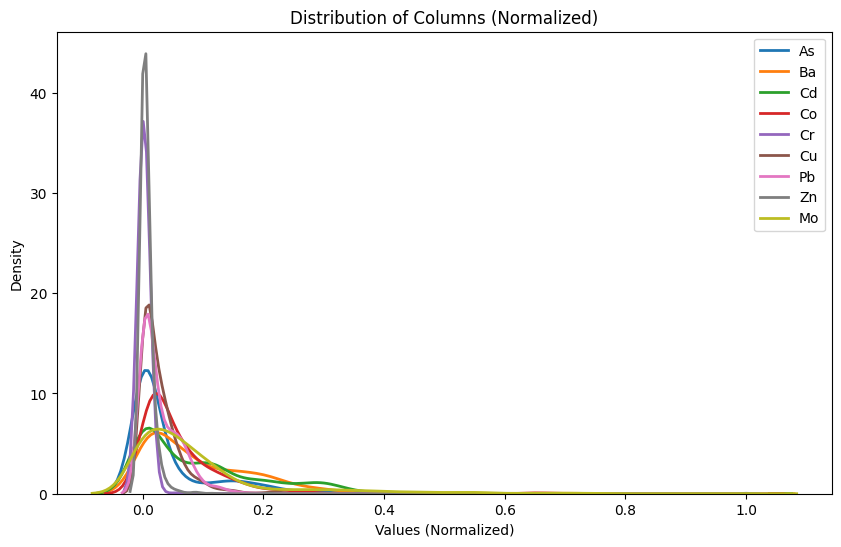

In [35]:
df = data.copy()

columns_to_plot = ['As', 'Ba', 'Cd', 'Co', 'Cr', 'Cu', 'Pb', 'Zn', 'Mo']

scaler = MinMaxScaler(feature_range=(0, 1))
df[columns_to_plot] = scaler.fit_transform(df[columns_to_plot])

plt.figure(figsize=(10, 6))
for col in columns_to_plot:
    sns.kdeplot(df[col], label=col, linewidth=2)

plt.title('Distribution of Columns (Normalized)')
plt.xlabel('Values (Normalized)')
plt.ylabel('Density')
plt.legend()
plt.show()

<AxesSubplot: >

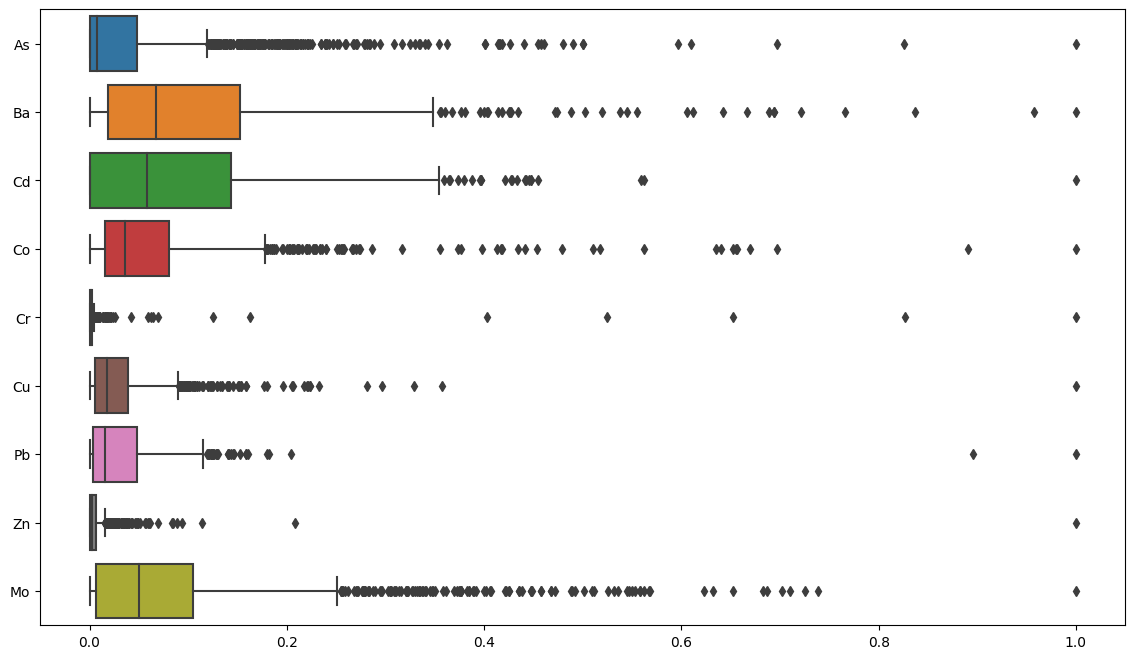

In [37]:
ax = sns.boxplot(data=df[columns_to_plot], orient='h')

ax.figure.set_size_inches(14, 8)    # Personalizando o tamanho da figura

#ax.set_title('Box-plot da RENDA por SEXO e COR', fontsize=18)    # Configurando o título do gráfico

#ax.set_xlabel('R$', fontsize=14)    # Configurando o label do eixo X

#ax.set_ylabel('Cor', fontsize=14)    # Configurando o label do eixo Y
#ax.set_yticklabels(['Indígena', 'Branca', 'Preta', 'Amarela', 'Parda'], fontsize=12)    # Configurando o label de cada categoria do eixo Y


ax

In [40]:
df['Cr'].describe()

count    1337.000000
mean        0.004790
std         0.044004
min         0.000000
25%         0.000812
50%         0.001476
75%         0.002146
max         1.000000
Name: Cr, dtype: float64

In [41]:
data['Cr'].describe()

count    1337.000000
mean        0.425973
std         3.913370
min         0.000000
25%         0.072240
50%         0.131275
75%         0.190835
max        88.932729
Name: Cr, dtype: float64

In [49]:
def prediction(i, data):

    SEED = 255
    np.random.seed(SEED)

    Class = pd.DataFrame()
    Class['Class'] = pd.cut(data[i],
                               bins = [data[i].min(), data[i].quantile(0.75), data[i].max()],
                               labels = [0, 1],
                               right = False)

    Class = pd.concat([Class, data.iloc[:,10:]], axis=1)
    x = Class.dropna().drop(columns=['Class'])
    y = Class['Class'].dropna()

    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            stratify=y)
    decision = DecisionTreeClassifier()
    decision.fit(x_train,y_train)

    print(f"A acurácia para {i} usando DecisionTree foi de %.2f%%" % (decision.score(x_test, y_test) * 100))

    Random = RandomForestClassifier()
    Random.fit(x_train,y_train)

    print(f"A acurácia para {i} usando RandomForest foi de %.2f%%" % (Random.score(x_test, y_test) * 100))
    
    xgb_classifier = xgb.XGBClassifier()
    xgb_classifier.fit(x_train, y_train)

    print(f"A acurácia para {i} usando XGBoost foi de %.2f%%" % (xgb_classifier.score(x_test, y_test) * 100))

In [50]:
def xgb_finetuning(i, data):
    
    SEED = 255
    np.random.seed(SEED)

    Class = pd.DataFrame()
    Class['Class'] = pd.cut(data[i],
                               bins = [data[i].min(), data[i].quantile(0.75), data[i].max()],
                               labels = [0, 1],
                               right = False)

    Class = pd.concat([Class, data.iloc[:,10:]], axis=1)
    x = Class.dropna().drop(columns=['Class'])
    y = Class['Class'].dropna()

    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            stratify=y)
    
    xgb_classifier = xgb.XGBClassifier()

    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.1, 0.2, 0.3],
        'subsample': [0.5, 1.0],
        'gamma': [0, 0.1]
    }

    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {i}: %.2f%%" % (accuracy * 100.0))

    print(f"Best Parameters for {i}: ", best_params)

In [51]:
for i in Elements:
    prediction(i, data)

A acurácia para As usando DecisionTree foi de 87.31%
A acurácia para As usando RandomForest foi de 89.93%
A acurácia para As usando XGBoost foi de 89.55%
A acurácia para Ba usando DecisionTree foi de 86.19%
A acurácia para Ba usando RandomForest foi de 89.55%
A acurácia para Ba usando XGBoost foi de 89.93%
A acurácia para Cd usando DecisionTree foi de 90.67%
A acurácia para Cd usando RandomForest foi de 94.03%
A acurácia para Cd usando XGBoost foi de 95.15%
A acurácia para Co usando DecisionTree foi de 80.97%
A acurácia para Co usando RandomForest foi de 85.07%
A acurácia para Co usando XGBoost foi de 86.57%
A acurácia para Cr usando DecisionTree foi de 84.70%
A acurácia para Cr usando RandomForest foi de 89.18%
A acurácia para Cr usando XGBoost foi de 89.18%
A acurácia para Cu usando DecisionTree foi de 80.22%
A acurácia para Cu usando RandomForest foi de 88.81%
A acurácia para Cu usando XGBoost foi de 86.94%
A acurácia para Pb usando DecisionTree foi de 82.09%
A acurácia para Pb usan

In [52]:
for i in Elements:
    xgb_finetuning(i, data)

Accuracy for As: 91.04%
Best Parameters for As:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
Accuracy for Ba: 86.94%
Best Parameters for Ba:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 1.0}
Accuracy for Cd: 95.15%
Best Parameters for Cd:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1.0}
Accuracy for Co: 86.57%
Best Parameters for Co:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 8, 'subsample': 1.0}
Accuracy for Cr: 90.30%
Best Parameters for Cr:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.5}
Accuracy for Cu: 88.81%
Best Parameters for Cu:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.5}
Accuracy for Pb: 87.69%
Best Parameters for Pb:  {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 4, 'subsample': 0.5}
Accuracy for Zn: 87.31%
Best Parameters for Zn:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
Accuracy for Mo: 84.33%
Best Parameters for Mo:  {'g

In [4]:
As_class = pd.DataFrame()
As_class['Class'] = pd.cut(data['As'],
                           bins = [data.As.min(), data.As.quantile(0.75), data.As.max()],
                           labels = [0, 1],
                           right = False)

As_class.Class.value_counts()

0    1002
1     334
Name: Class, dtype: int64

In [7]:
data.iloc[:,10:].head(1)

,scan_mir.600_abs,scan_mir.602_abs,scan_mir.604_abs,scan_mir.606_abs,scan_mir.608_abs,scan_mir.610_abs,scan_mir.612_abs,scan_mir.614_abs,scan_mir.616_abs,scan_mir.618_abs,...,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
0,1514,1512,1518,1530,1552,1581,1615,1650,1683,1712,...,257,257,257,257,257,257,257,257,257,257


In [8]:
As_class = pd.concat([As_class, data.iloc[:,10:]], axis=1)

As_class.head(1)

,Class,scan_mir.600_abs,scan_mir.602_abs,scan_mir.604_abs,scan_mir.606_abs,scan_mir.608_abs,scan_mir.610_abs,scan_mir.612_abs,scan_mir.614_abs,scan_mir.616_abs,...,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
0,1,1514,1512,1518,1530,1552,1581,1615,1650,1683,...,257,257,257,257,257,257,257,257,257,257


In [10]:
x = As_class.dropna().drop(columns=['Class'])
y = As_class['Class'].dropna()

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)

A acurácia foi de 85.45%


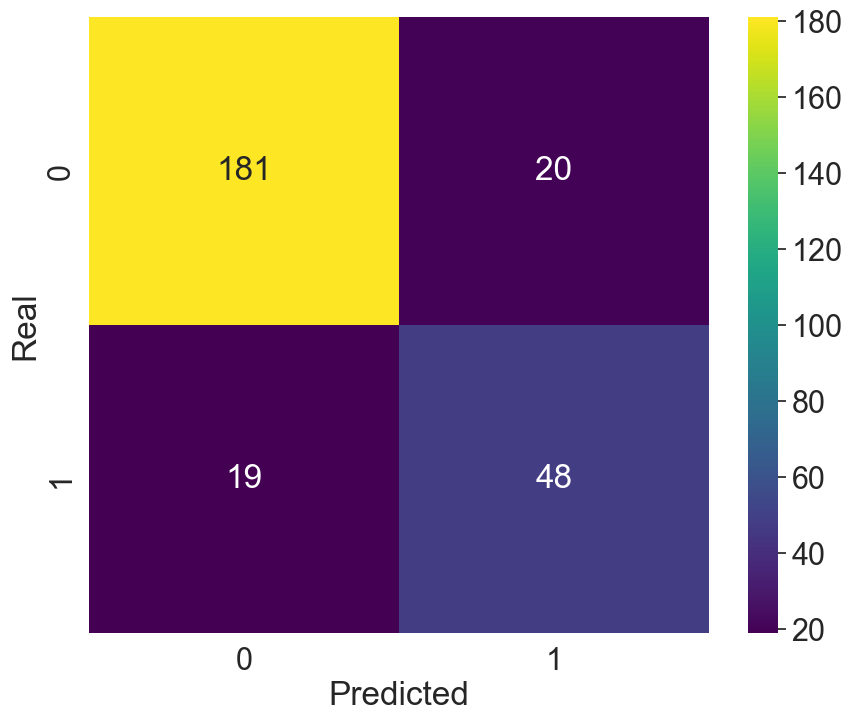

In [13]:
model = DecisionTreeClassifier()
model.fit(x_train,y_train)

confusion = confusion_matrix(y_test, model.predict(x_test))

plt.figure(figsize = (10,8))
sns.set(font_scale=2)
sns.heatmap(confusion, 
            annot = True, 
            fmt = "d", 
            cmap='viridis').set(xlabel = "Predicted", 
                                ylabel = "Real")


print("A acurácia foi de %.2f%%" % (model.score(x_test, y_test) * 100))

A acurácia foi de 88.43%


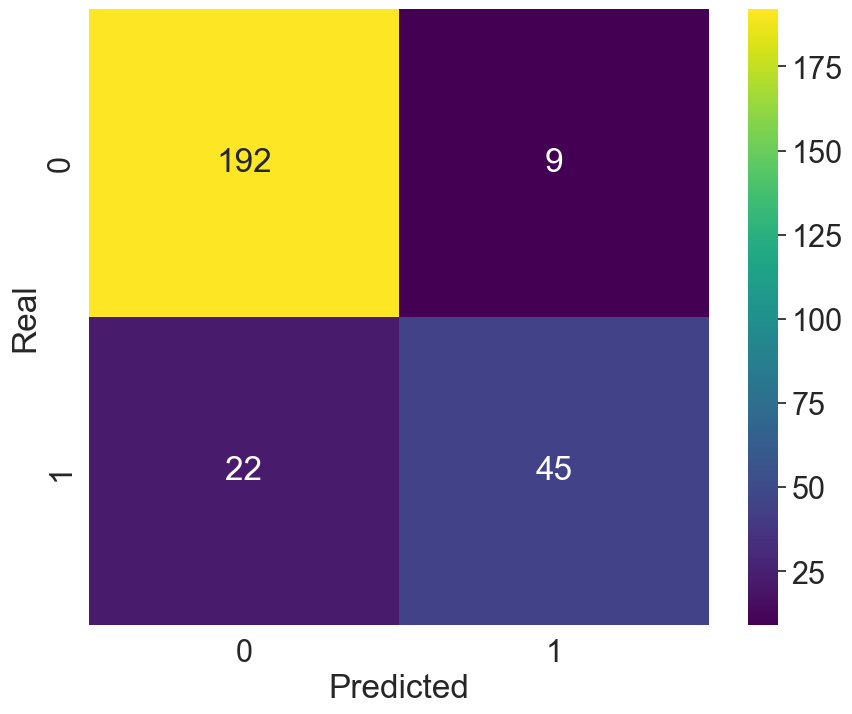

In [12]:
x = As_class.dropna().drop(columns=['Class'])
y = As_class['Class'].dropna()

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)

model = RandomForestClassifier()
model.fit(x_train,y_train)

confusion = confusion_matrix(y_test, model.predict(x_test))

plt.figure(figsize = (10,8))
sns.set(font_scale=2)
sns.heatmap(confusion, 
            annot = True, 
            fmt = "d", 
            cmap='viridis').set(xlabel = "Predicted", 
                                ylabel = "Real")

print("A acurácia foi de %.2f%%" % (model.score(x_test, y_test) * 100))

In [13]:
import time

SEED = 255
np.random.seed(SEED)

tic = time.time()
modelo = DecisionTreeClassifier(max_depth=5)
cv = StratifiedKFold(n_splits = 10, shuffle=True)
results = cross_validate(modelo, x, y, cv = cv, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

print(time.time() - tic)

Accuracy com cross validation, 10 = [67.76, 81.48]
14.506636619567871


In [14]:
tic = time.time()
modelo = RandomForestClassifier(max_depth=80, criterion='entropy')
cv = StratifiedKFold(n_splits = 10, shuffle=True)
results = cross_validate(modelo, x, y, cv = cv, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))
print(time.time() - tic)

Accuracy com cross validation, 10 = [70.14, 87.19]
71.23092579841614


In [28]:
As_class = pd.DataFrame()
As_class['Class'] = pd.cut(data['As'],
                           bins = [data.As.min(), 1, data.As.max()],
                           labels = [0, 1],
                           right = False)

As_class = pd.concat([As_class, data.iloc[:,10:]], axis=1)

x = As_class.dropna().drop(columns=['Class'])
y = As_class['Class'].dropna()

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y)